# Monthly Rain Reports


In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import contextily as cx

from raindownloader.inpeparser import INPE, INPEParsers, INPETypes
from raindownloader.downloader import Downloader
from raindownloader.utils import FileType
from rainreporter.reporter import RainReporter

import rasterio as rio
import xarray as xr
from raindownloader.utils import GISUtil

## Opening Basins of INterest

In [2]:
shapes_mac = Path('/Users/cordmaur/Library/CloudStorage/OneDrive-AgênciaNacionaldeÁguas/Trabalho/SOE/COVEC/Bases/bacias de interesse SOE')
shapes_container = Path('/workspaces/bases/bacias de interesse SOE')

shapes = shapes_mac if shapes_mac.exists() else shapes_container
assert shapes.exists()

In [3]:
basins = {file.stem.split('_')[-1]: file for file in shapes.iterdir() if file.suffix == '.shp'}

In [4]:
basins

{'Doce': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce.shp'),
 'wgs84': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Doce_wgs84.shp'),
 'Itapecuru': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Itapecuru.shp'),
 'Jequitinhonha': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Jequitinhonha.shp'),
 'Madeira': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira.shp'),
 'PortoVelho': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Madeira_em_PortoVelho.shp'),
 'Negro': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Negro.shp'),
 'Paraguai': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Paraguai.shp'),
 'ParaibaDoSul': PosixPath('/workspaces/bases/bacias de interesse SOE/bacias50k_ParaibaDoSul.shp'),
 'Parana': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Parana.shp'),
 'Pardo': PosixPath('/workspaces/bases/bacias de interesse SOE/bacia_Pardo.shp'),
 'Parnaiba': PosixPa

## Creating the Reporter Object

In [5]:
reporter = RainReporter(
    server=INPEParsers.FTPurl, 
    download_folder='/workspaces/INPERainDownloader/tmp', 
    parsers=INPEParsers.parsers,
    post_processors=INPEParsers.post_processors
)


## Anomalies

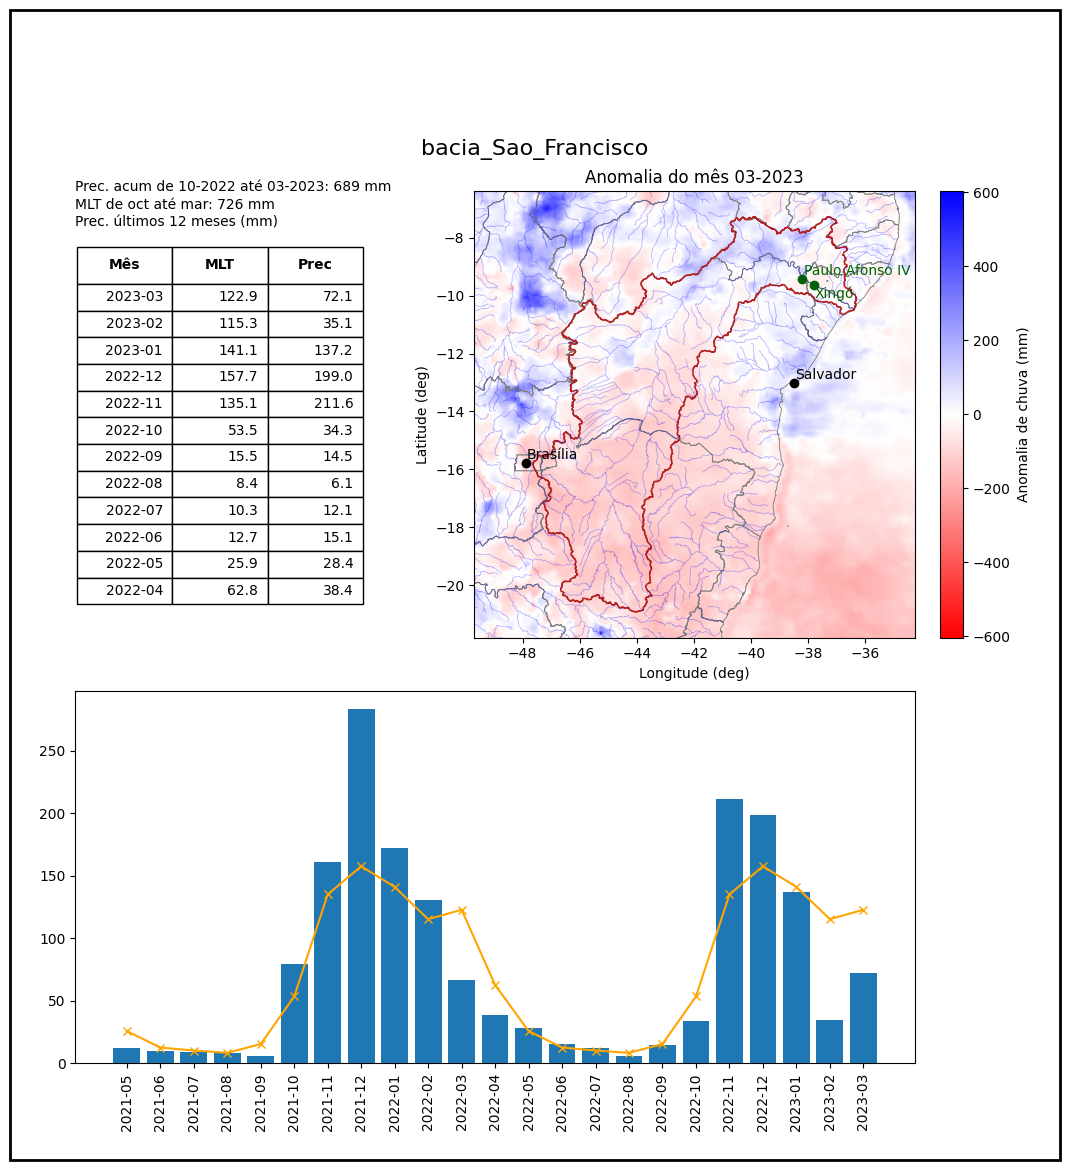

In [6]:
axs, rain_ts, lta, shp = reporter.monthly_anomaly_report(
    date_str='2023-03',
    shapefile=basins['Francisco'],
)

In [7]:
# fig, ax = plt.subplots(figsize=(4, 8))
ax = axs[0]
fig = ax.figure


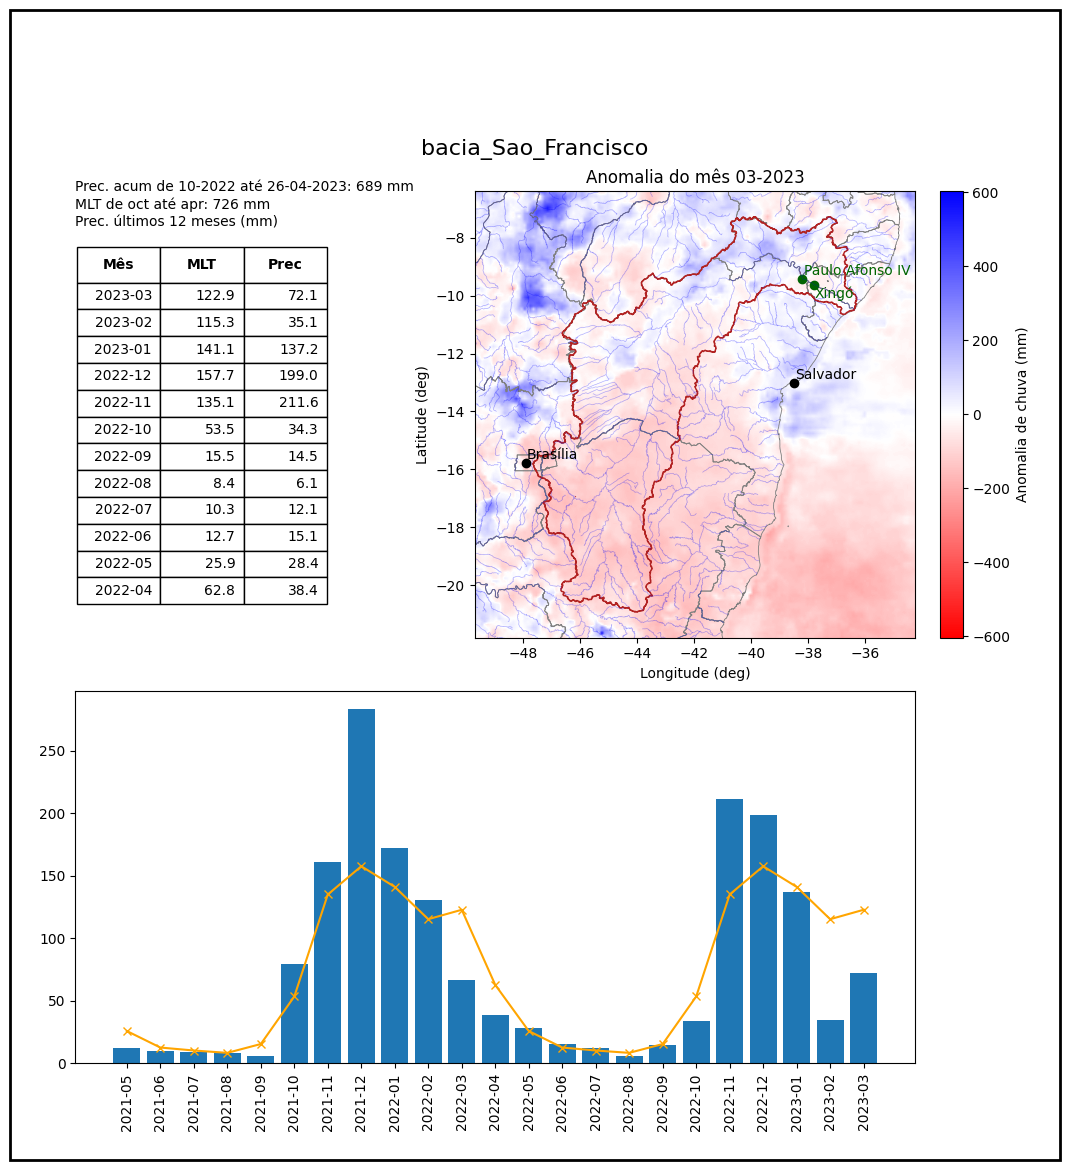

In [8]:
from datetime import datetime
ax.clear()
reporter.write_tabular_monthly(
    plt_ax=ax,
    rain_ts=rain_ts,
    lta_ts=lta,
    last_date=datetime.now()
)

fig

In [9]:
begin_wet_perid = 10

In [10]:
lta_ts = lta
# create a dataframe to plot as a table
rain_df = rain_ts.rename("Prec_f").to_frame()
rain_df["MLT_f"] = lta_ts.values
rain_df["MLT"] = rain_df["MLT_f"].apply(lambda x: f"{x:.1f}")
rain_df["Prec"] = rain_df["Prec_f"].apply(lambda x: f"{x:.1f}")
rain_df["Mês"] = rain_df.index.astype("str")
rain_df["Mês"] = rain_df["Mês"].str[:7]
rain_df = rain_df.sort_index(ascending=False)

In [11]:
# get the months where the wet period begins
# and extract the last period
last_wet_period = rain_df[rain_df.index.month == begin_wet_perid].index[0]
last_wet_period


Timestamp('2022-10-01 12:00:00')

In [61]:
# Now, with the last wet period selected, let's get all the rows up to present
rain_wet = rain_df[rain_df.index >= last_wet_period]

In [62]:
rain_wet

,Prec_f,MLT_f,MLT,Prec,Mês,month
time,,,,,,
2023-03-01 12:00:00,72.087288,25.867737,25.9,72.1,2023-03,3
2023-02-01 12:00:00,35.069046,12.653066,12.7,35.1,2023-02,2
2023-01-01 12:00:00,137.223618,10.283754,10.3,137.2,2023-01,1
2022-12-01 12:00:00,198.962265,8.403646,8.4,199.0,2022-12,12
2022-11-01 12:00:00,211.573914,15.464760,15.5,211.6,2022-11,11
2022-10-01 12:00:00,34.251518,53.478138,53.5,34.3,2022-10,10


In [21]:
rain_df.index = pd.to_datetime(rain_df.index)

In [23]:
pd.DatetimeIndex(rain_df.index)

DatetimeIndex(['2023-03-01 12:00:00', '2023-02-01 12:00:00',
               '2023-01-01 12:00:00', '2022-12-01 12:00:00',
               '2022-11-01 12:00:00', '2022-10-01 12:00:00',
               '2022-09-01 12:00:00', '2022-08-01 12:00:00',
               '2022-07-01 12:00:00', '2022-06-01 12:00:00',
               '2022-05-01 12:00:00', '2022-04-01 12:00:00',
               '2022-03-01 12:00:00', '2022-02-01 12:00:00',
               '2022-01-01 12:00:00', '2021-12-01 12:00:00',
               '2021-11-01 12:00:00', '2021-10-01 12:00:00',
               '2021-09-01 12:00:00', '2021-08-01 12:00:00',
               '2021-07-01 12:00:00', '2021-06-01 12:00:00',
               '2021-05-01 12:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [22]:
rain_df.index

DatetimeIndex(['2023-03-01 12:00:00', '2023-02-01 12:00:00',
               '2023-01-01 12:00:00', '2022-12-01 12:00:00',
               '2022-11-01 12:00:00', '2022-10-01 12:00:00',
               '2022-09-01 12:00:00', '2022-08-01 12:00:00',
               '2022-07-01 12:00:00', '2022-06-01 12:00:00',
               '2022-05-01 12:00:00', '2022-04-01 12:00:00',
               '2022-03-01 12:00:00', '2022-02-01 12:00:00',
               '2022-01-01 12:00:00', '2021-12-01 12:00:00',
               '2021-11-01 12:00:00', '2021-10-01 12:00:00',
               '2021-09-01 12:00:00', '2021-08-01 12:00:00',
               '2021-07-01 12:00:00', '2021-06-01 12:00:00',
               '2021-05-01 12:00:00'],
              dtype='datetime64[ns]', name='time', freq=None)

In [74]:
from raindownloader.utils import DateProcessor

last_date = None

if last_date is None:
    last_date = rain_df.index[0]
    last_date_str = DateProcessor.pretty_date(last_date, "%m-%Y")
else:
    last_date_str = DateProcessor.pretty_date(last_date, "%d-%m-%Y")

accum_rain = round(rain_wet['Prec_f'].sum())
accum_mlt = round(rain_wet['MLT_f'].sum())

accum_text = f'Prec. acum de {DateProcessor.pretty_date(last_wet_period, "%m-%Y")} até {last_date_str}: {accum_rain} mm'
mlt_text = f'MLT de {DateProcessor.month_abrev(last_wet_period)} até {DateProcessor.month_abrev(last_date)}: {accum_mlt} mm'
accum_text, mlt_text

('Prec. acum de 10-2022 até 03-2023: 689 mm', 'MLT de oct até mar: 126 mm')

In [73]:
DateProcessor.month_abrev(last_date)

'mar'

In [50]:
accum_rain.sum()

Prec_f                                    689.167664
MLT_f                                     126.151093
MLT                          25.912.710.38.415.553.5
Prec                     72.135.1137.2199.0211.634.3
Mês       2023-032023-022023-012022-122022-112022-10
month                                             39
dtype: object

In [31]:
current_date = rain_df.index[0]

In [33]:
current_date.year

2023

In [41]:
last_october

,Prec_f,MLT_f,MLT,Prec,Mês,month
time,,,,,,
2022-10-01 12:00:00,34.251518,53.478138,53.5,34.3,2022-10,10
2021-10-01 12:00:00,79.366776,53.478138,53.5,79.4,2021-10,10


In [25]:
rain_df['month'] = rain_df.index.month

In [26]:
rain_df

,Prec_f,month
time,,
2023-03-01 12:00:00,72.087288,3
2023-02-01 12:00:00,35.069046,2
2023-01-01 12:00:00,137.223618,1
2022-12-01 12:00:00,198.962265,12
2022-11-01 12:00:00,211.573914,11
2022-10-01 12:00:00,34.251518,10
2022-09-01 12:00:00,14.475023,9
2022-08-01 12:00:00,6.115089,8
2022-07-01 12:00:00,12.086970,7


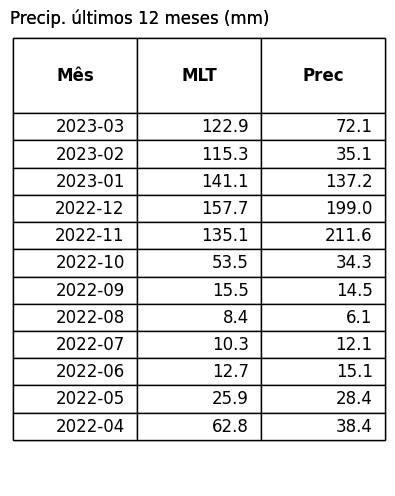

In [57]:
ax.figure

In [ ]:
RainReporter.

In [21]:
reporter.plot_dams(ax, n_dams=5)

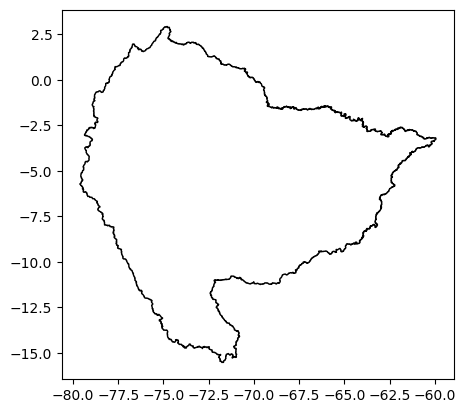

In [23]:
ax.figure

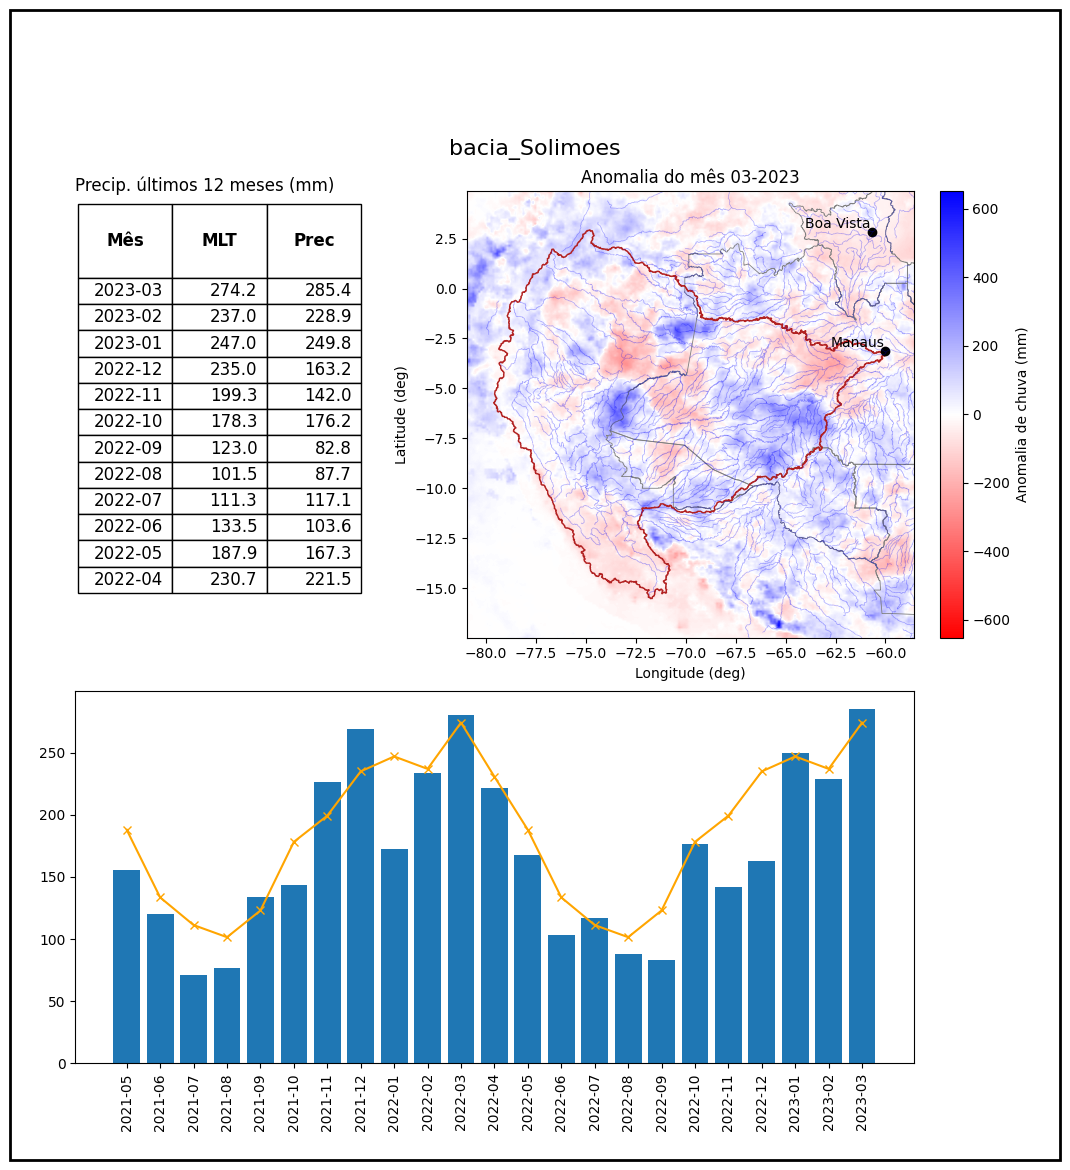

In [18]:
fig

In [33]:
# load the dams
dams = gpd.read_file('/workspaces/RainReporter/data/dams')
dams.head(3)

,NOME,propriet,RIO,potencia,ini_oper,ceg,created_us,created_da,last_edite,last_edi_1,geometry
0,Glória,Companhia Vale do Rio Doce,Rio Glória,13800.0,1983-01-01,UHE.PH.MG.001034-0.01,BERNARDO.OLIVEIRA,2022-03-15,BERNARDO.OLIVEIRA,2022-03-15,POINT (-42.32900 -21.03987)
1,Suíça,EDP Pequenas Centrais Hidrelétricas S.A.,Rio Santa Maria,35337.0,1965-01-01,UHE.PH.ES.002781-2.01,BERNARDO.OLIVEIRA,2022-03-15,BERNARDO.OLIVEIRA,2022-03-15,POINT (-40.57701 -20.08315)
2,Pedra,Companhia Hidro Elétrica do São Francisco,Rio das Contas,20007.0,1978-11-13,UHE.PH.BA.027052-0.01,BERNARDO.OLIVEIRA,2022-03-15,BERNARDO.OLIVEIRA,2022-03-15,POINT (-40.23576 -13.86835)


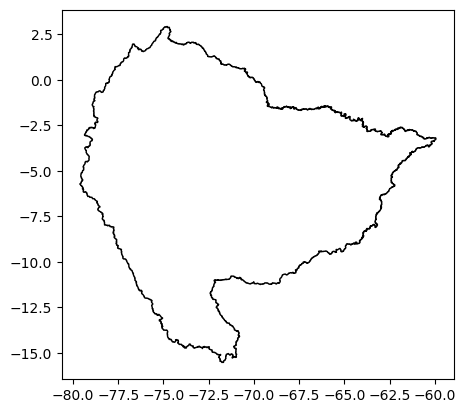

In [34]:
ax = shp.plot(facecolor='none')

In [41]:
n_dams = 4
RainReporter.plot_points(
    points=dams,
    plt_ax=ax,
    text_column='NOME',
    qry=f"potencia >= potencia.nlargest({n_dams}).min()",
    color='darkgreen'
)

<Figure size 640x480 with 0 Axes>

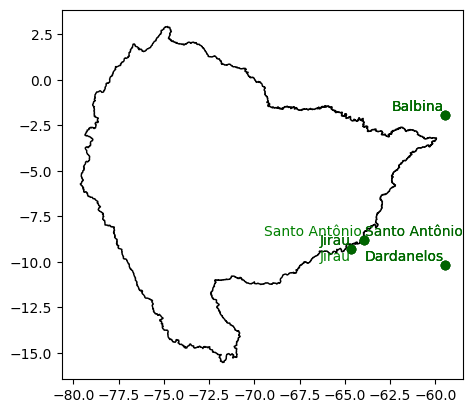

In [42]:
ax.figure

<Axes: >

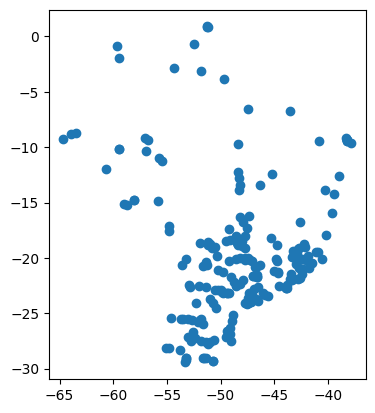

In [12]:
dams.plot()

In [13]:
dams.clip_by_rect(-60, -30, -50, -20)

0         GEOMETRYCOLLECTION EMPTY
1         GEOMETRYCOLLECTION EMPTY
2         GEOMETRYCOLLECTION EMPTY
3         GEOMETRYCOLLECTION EMPTY
4      POINT (-50.40639 -24.53417)
                  ...             
215       GEOMETRYCOLLECTION EMPTY
216       GEOMETRYCOLLECTION EMPTY
217    POINT (-52.95868 -22.47567)
218       GEOMETRYCOLLECTION EMPTY
219       GEOMETRYCOLLECTION EMPTY
Length: 220, dtype: geometry

In [15]:
dams['potencia']

0        13800.0
1        35337.0
2        20007.0
3         8780.0
4        36000.0
         ...    
215     392950.0
216      90820.0
217    1540000.0
218     131490.0
219      18012.0
Name: potencia, Length: 220, dtype: float64

In [ ]:
dams.query("potencia ")

In [18]:
pd.Series.nlargest?

Signature:
pd.Series.nlargest(
    self,
    n: 'int' = 5,
    keep: "Literal['first', 'last', 'all']" = 'first',
) -> 'Series'
Docstring:
Return the largest `n` elements.

Parameters
----------
n : int, default 5
    Return this many descending sorted values.
keep : {'first', 'last', 'all'}, default 'first'
    When there are duplicate values that cannot all fit in a
    Series of `n` elements:

    - ``first`` : return the first `n` occurrences in order
      of appearance.
    - ``last`` : return the last `n` occurrences in reverse
      order of appearance.
    - ``all`` : keep all occurrences. This can result in a Series of
      size larger than `n`.

Returns
-------
Series
    The `n` largest values in the Series, sorted in decreasing order.

See Also
--------
Series.nsmallest: Get the `n` smallest elements.
Series.sort_values: Sort Series by values.
Series.head: Return the first `n` rows.

Notes
-----
Faster than ``.sort_values(ascending=False).head(n)`` for small `n`
relative 

In [19]:
dams.potencia.nlargest(3)

61     11233100.0
191     8535000.0
213     7000000.0
Name: potencia, dtype: float64

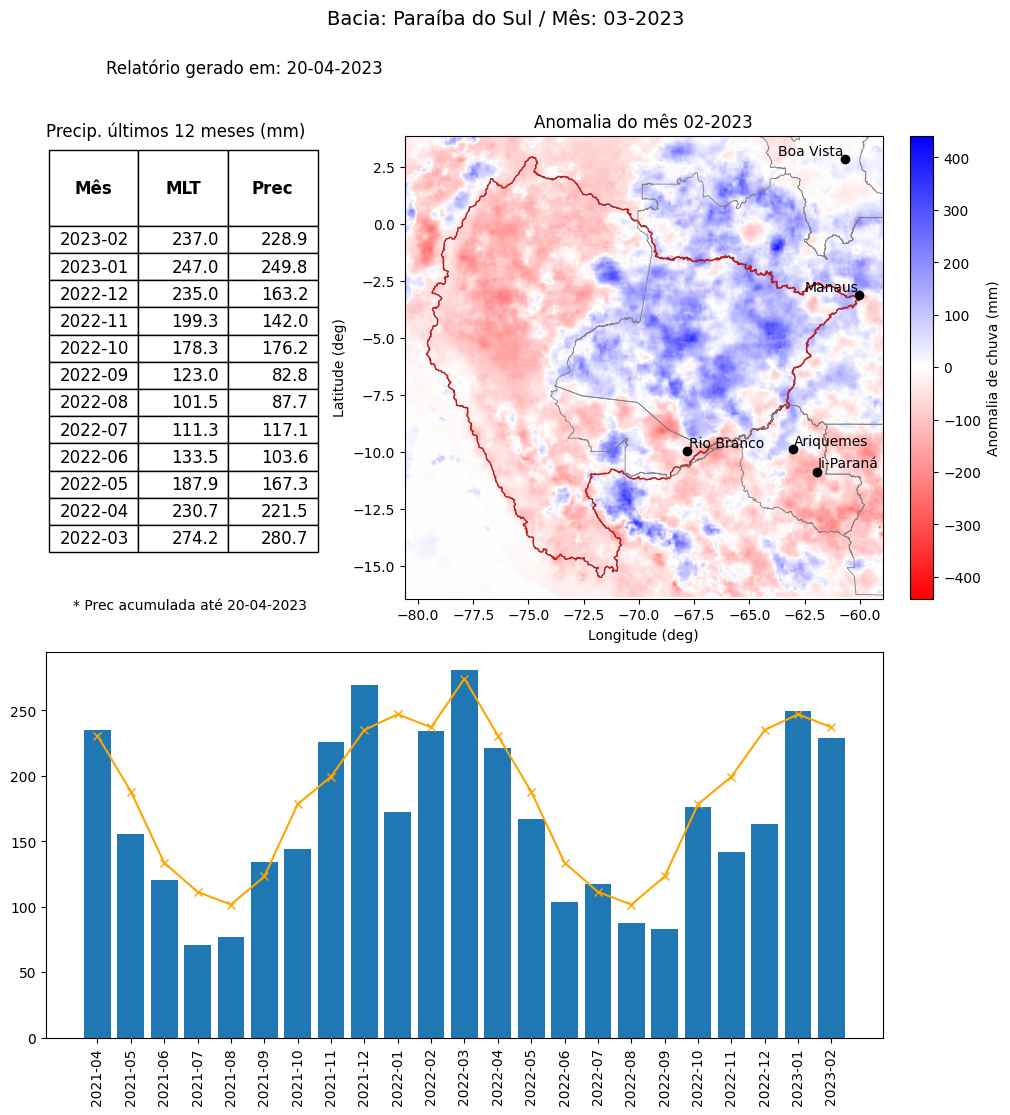

In [54]:
fig.suptitle('Bacia: Paraíba do Sul / Mês: 03-2023', y=1.1, fontsize=14)
subtitle = "Relatório gerado em: 20-04-2023"
fig.text(0.1, 1.05, subtitle, ha='left', va='top', fontsize=12)

ax.text(0.1, 0.05, "* Prec acumulada até 20-04-2023", ha='left', va='top')
fig

In [56]:
downloader = reporter.downloader

In [57]:
downloader.remote_file_exists('20230421', INPETypes.DAILY_RAIN)

False

In [63]:
import io

In [107]:
target = io.BytesIO()

In [108]:
fig.savefig(target, bbox_inches='tight', pad_inches=0.5, format='pdf')

In [171]:
from pypdf import PdfWriter, PdfReader, PdfMerger

In [118]:
output_folder = Path('../tmp/output')

In [148]:
files = [PdfReader(f, strict=True) for f in output_folder.glob('*.pdf')]

In [173]:
merger.append(files[0])

In [174]:
merger.write('../tmp/merged.pdf')

In [172]:
pdf_doc = PdfWriter()
merger = PdfMerger()

In [ ]:
merger.ap

In [168]:
pdf_doc.append_pages_from_reader(files[0])
pdf_doc.append_pages_from_reader(files[1])


In [169]:
file, buffer = pdf_doc.write('../report.pdf')

In [152]:
file = files[0]

In [154]:
page = file.pages[0]

In [156]:
page.extract_text()

'Mês MLT Prec\n2023-02 166.2 205.6\n2023-01 218.3 220.5\n2022-12 190.9 189.6\n2022-11 156.3 88.9\n2022-10 134.2 145.1\n2022-09 76.8 118.9\n2022-08 39.7 67.0\n2022-07 39.2 7.6\n2022-06 51.8 50.4\n2022-05 73.9 63.0\n2022-04 82.6 95.1\n2022-03 145.6 169.3Precip. últimos 12 meses (mm)\n56\n 54\n 52\n 50\n 48\n 46\n 44\nLongitude (deg)26\n24\n22\n20\n18\n16\nLatitude (deg)\nSão PauloRio de JaneiroBrasília\nBelo Horizonte\nCuritibaAnomalia do mês 02-20232021-04\n2021-05\n2021-06\n2021-07\n2021-08\n2021-09\n2021-10\n2021-11\n2021-12\n2022-01\n2022-02\n2022-03\n2022-04\n2022-05\n2022-06\n2022-07\n2022-08\n2022-09\n2022-10\n2022-11\n2022-12\n2023-01\n2023-02050100150200\n1000\n500\n05001000\nAnomalia de chuva (mm)__Bacia: Paraiba do SulParana / Mês: 02-2023\nRelatório gerado em: 21-04-2023'

In [158]:
pdf_doc.getNumPages

<bound method PdfWriter.getNumPages of <pypdf._writer.PdfWriter object at 0xffff7c7a95a0>>

In [159]:
pdf_doc.pages[0].extract_text()

'Mês MLT Prec\n2023-02 166.2 205.6\n2023-01 218.3 220.5\n2022-12 190.9 189.6\n2022-11 156.3 88.9\n2022-10 134.2 145.1\n2022-09 76.8 118.9\n2022-08 39.7 67.0\n2022-07 39.2 7.6\n2022-06 51.8 50.4\n2022-05 73.9 63.0\n2022-04 82.6 95.1\n2022-03 145.6 169.3Precip. últimos 12 meses (mm)\n56\n 54\n 52\n 50\n 48\n 46\n 44\nLongitude (deg)26\n24\n22\n20\n18\n16\nLatitude (deg)\nSão PauloRio de JaneiroBrasília\nBelo Horizonte\nCuritibaAnomalia do mês 02-20232021-04\n2021-05\n2021-06\n2021-07\n2021-08\n2021-09\n2021-10\n2021-11\n2021-12\n2022-01\n2022-02\n2022-03\n2022-04\n2022-05\n2022-06\n2022-07\n2022-08\n2022-09\n2022-10\n2022-11\n2022-12\n2023-01\n2023-02050100150200\n1000\n500\n05001000\nAnomalia de chuva (mm)__Bacia: Paraiba do SulParana / Mês: 02-2023\nRelatório gerado em: 21-04-2023'

In [165]:
buffer = io.BytesIO()

In [166]:
pdf_doc.write(buffer)

(False, <_io.BytesIO at 0xffff7c408cc0>)

In [164]:
buffer.getvalue()

ValueError: I/O operation on closed file.

In [ ]:
pdf_doc.app

In [149]:
pdf_doc.write?

Signature: pdf_doc.write(stream: Union[pathlib.Path, str, IO]) -> Tuple[bool, IO]
Docstring:
Write the collection of pages added to this object out as a PDF file.

Args:
    stream: An object to write the file to.  The object can support
        the write method and the tell method, similar to a file object, or
        be a file path, just like the fileobj, just named it stream to keep
        existing workflow.

Returns:
    A tuple (bool, IO)
File:      /usr/local/lib/python3.10/dist-packages/pypdf/_writer.py
Type:      method

In [151]:
pdf_doc.write(output_folder/'report.pdf')

(True, <_io.FileIO [closed]>)

In [141]:
page = files[0].pages[0]

TypeError: DictionaryObject.write_to_stream() missing 1 required positional argument: 'encryption_key'

In [94]:
merger = PdfWriter()

In [111]:
pdf_page = PdfReader(target)

In [112]:
pdf_page

In [117]:
len(pdf_page.pages)

1

In [ ]:

pdf_file = merger.append(pdf_page)

In [15]:
shp = gpd.read_file(basins['Solimoes'])

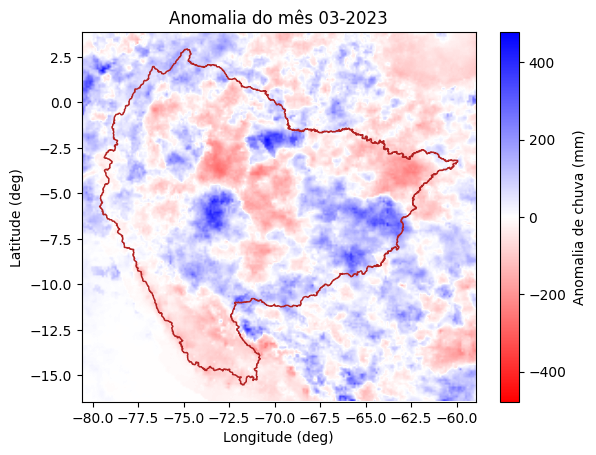

In [16]:
fig, ax = plt.subplots()
reporter.plot_anomaly_map(
    '2023-03',
    shp,
    ax
)

In [17]:
xmin, xmax, ymin, ymax = ax.axis()


In [18]:
xmin, xmax, ymin, ymax

(-80.60062339999999, -58.9559102, -16.448344715, 3.8595014149999995)

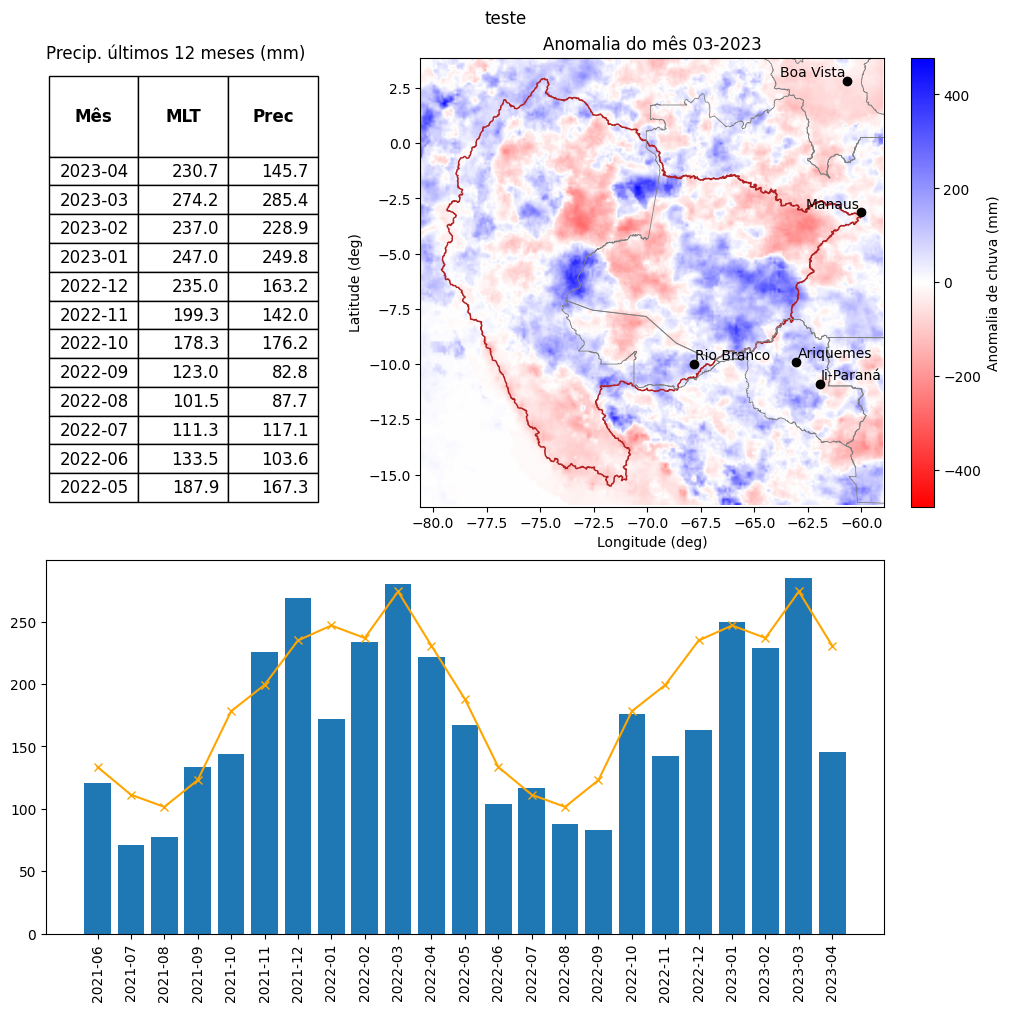

In [ ]:
fig.sup

In [ ]:
downloader = reporter.downloader

In [ ]:
parser = downloader.get_parser(datatype=INPETypes.MONTHLY_ACCUM_MANUAL)

In [ ]:
file = parser.get_file('2023-05', downloader.local_folder)
file

NameError: name 'parser' is not defined

In [ ]:
dset = xr.open_dataset(file)
dset.sum()

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    step         timedelta64[ns] ...
    surface      float64 ...
    spatial_ref  int64 ...
Data variables:
    monthacum    float32 7.987e+06

In [ ]:
dset.close()

In [ ]:
file = Path('/workspaces/INPERainDownloader/tmp/MONTHLY_ACCUM_MANUAL/MERGE_CPTEC_acum_apr_2023.nc')

In [ ]:
file.unlink()

In [ ]:
for day in range(20, 1, -1):
    print(day)

20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2


In [ ]:
rain_df = rain_ts.rename('Prec_f').to_frame()
rain_df['MLT_f'] = lta.values
rain_df['MLT'] = rain_df['MLT_f'].apply(lambda x: f'{x:.1f}')
rain_df['Prec'] = rain_df['Prec_f'].apply(lambda x: f'{x:.1f}')
rain_df['Mês'] = rain_df.index.astype('str')
rain_df['Mês'] = rain_df['Mês'].str[:7]
rain_df = rain_df.sort_index(ascending=False)

rain_df = rain_df[['Mês', 'MLT', 'Prec']]
rain_df.iloc[:6]

,Mês,MLT,Prec
time,,,
2023-04-01 12:00:00,2023-04,62.8,26.6
2023-03-01 12:00:00,2023-03,122.9,72.1
2023-02-01 12:00:00,2023-02,115.3,35.1
2023-01-01 12:00:00,2023-01,141.1,137.2
2022-12-01 12:00:00,2022-12,157.7,199.0
2022-11-01 12:00:00,2022-11,135.1,211.6


In [ ]:
ax = axs[0]

In [ ]:
table = ax.table(cellText=rain_df.iloc[:12].values, colLabels=rain_df.columns, 
                 loc='top', bbox=[0.01, 0.01, 1., 0.95])
# set table properties
table.auto_set_font_size(False)
table.set_fontsize(12)


# set table row heights
for i in range(3):
    table[0, i].set_height(0.1)
    table[0, i].set_text_props(weight='bold')


ax.axis('off')

(0.0, 1.0, 0.0, 1.0)

In [ ]:
ax.text(0, 1, "Precip. últimos 12 meses (mm)", fontsize=12)

Text(0, 1, 'Precip. últimos 12 meses (mm)')

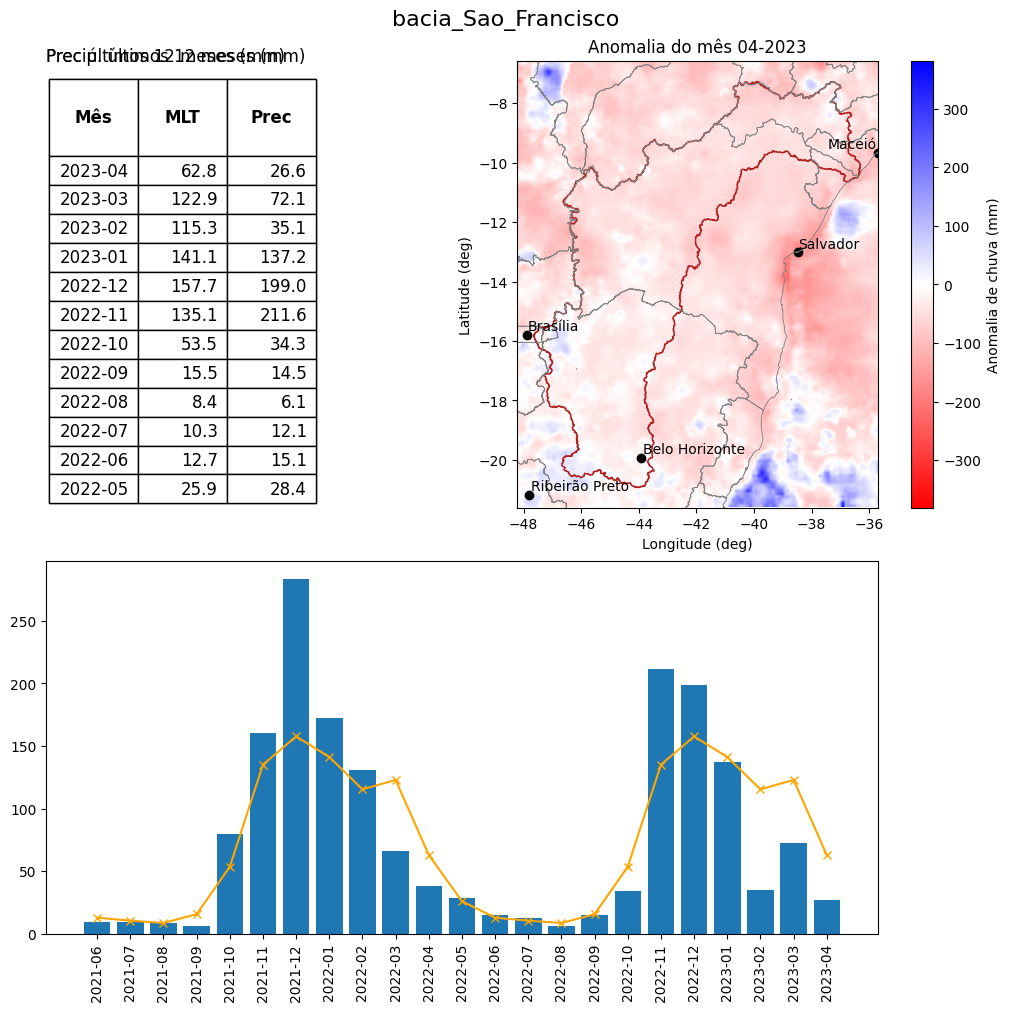

In [ ]:
ax.figure

In [ ]:
rain_df.columns.to_list()

['Mês', 'MLT', 'Prec']

In [ ]:
import pandas as pd
pd.DataFrame([lta, rain_ts])

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
rain_ts[-3:]

time
2023-02-01 12:00:00    35.069046
2023-03-01 12:00:00    72.087288
2023-04-01 12:00:00    26.572010
Name: monthacum, dtype: float32

In [ ]:
from raindownloader.utils import DateProcessor

In [ ]:
DateProcessor.pretty_date('2023-03', '%m-%Y')

'03-2023'

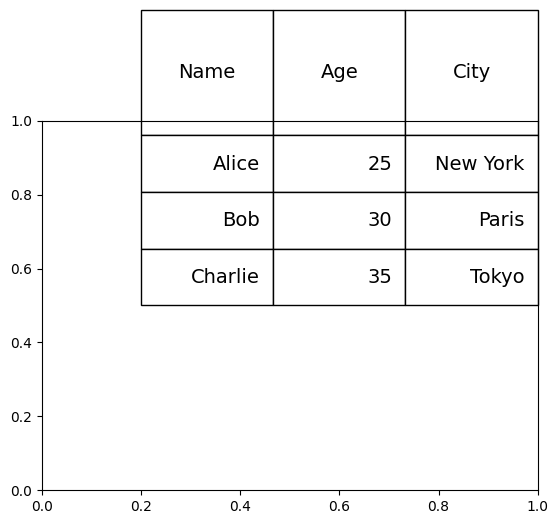

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# create a DataFrame with some sample data
data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [25, 30, 35],
        'City': ['New York', 'Paris', 'Tokyo']}

df = pd.DataFrame(data)

# create a figure and axis
fig, ax = plt.subplots()

# create a table from the DataFrame
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', bbox=[0.2, 0.5, 0.8, 0.8])

# set table properties
table.auto_set_font_size(False)
table.set_fontsize(14)

# set table row heights
for i in range(len(df)):
    table[0,i].set_height(0.1)

plt.show()


In [ ]:
table[0, 0]

In [ ]:
parser = reporter.downloader.get_parser(INPETypes.DAILY_RAIN)

In [ ]:
files = parser.get_range(
    start_date='20230401',
    end_date='20230418',
    local_folder='/workspaces/INPERainDownloader/tmp',
    force_download=True
)

In [ ]:
files

[PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230401.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230402.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230403.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230404.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230405.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230406.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230407.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230408.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230409.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230410.grib2'),
 PosixPath('/workspaces/INPERainDownloader/tmp/DAILY_RAIN/MERGE_CPTEC_20230411.grib2'),
 PosixPath('/workspaces/INPERain

In [ ]:
from raindownloader.utils import GISUtil
import xarray as xr

In [ ]:
xr.open_dataset('../MERGE_CPTEC_20230407.grib2')

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-04-18T17:23 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
xr.open_dataset(files[7])

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-04-18T17:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
cube = GISUtil.create_cube(
    files=files[:-1],
    dim_key='time'
)

In [ ]:
cube = INPE.grib2_post_proc(cube)

In [ ]:
accum = cube[INPETypes.DAILY_RAIN.value['var']].sum(dim="time")


In [ ]:
cube

NameError: name 'cube' is not defined